## Homework 13: The Moriarty Brain Atlas
##### By Kevin Liu

#### 1. Verify That PCA Fails

First, we will reproduce Moriarty's result by using PCA to project the data into two dimensions and plot our PCA projections for the two data sets, with points colored according to their known cell types.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from sklearn.manifold import TSNE

Color = [ 'xkcd:red',    'xkcd:green',  'xkcd:magenta', 'xkcd:blue',
          'xkcd:purple', 'xkcd:orange', 'xkcd:cyan',    'xkcd:lime',
          'xkcd:pink',   'xkcd:yellow', 'xkcd:teal',    'xkcd:lavender',
          'xkcd:brown',  'xkcd:maroon', 'xkcd:olive',   'xkcd:navy' ]

In [2]:
def read_data(infile):
    """
    Modified based on http://mcb112.org/w13/pca-figs.py
    Reads in the data.
    """
    df    = pd.read_table(infile)
    ctype = list(df['type'])
    df    = df.drop('type', axis = 1)
    (ncells, ngenes) = df.shape
    X     = df.values.astype(float)
    
    return X, ctype, ncells, ngenes, infile


def log_transform(X, ncells, ngenes):
    """
    Modified based on http://mcb112.org/w13/pca-figs.py
    Log-transforms the data.
    """
    for i in range(ncells):
        for g in range(ngenes):
            X[i, g] = np.log(X[i, g] + 1.0)
    
    return X


def PCA(X, ncells, ctype, infile):
    """
    Modified based on http://mcb112.org/w13/pca-figs.py
    Uses PCA to project the data into two dimensions.
    """
    Xs = X - np.mean(X, axis = 0)
    U, S, Wt = np.linalg.svd(Xs)
    W = np.transpose(Wt)
    X2 = Xs @ W[:, :2]
    
    fig, ax = plt.subplots(1, 1)
    for i in range(ncells):
        ax.plot(X2[i, 0], X2[i, 1], 'o', markersize = 4, mfc = 'w', mec = Color[ctype[i]%16])
    ax.set_title("Projections onto the first two principal axes for " + infile)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

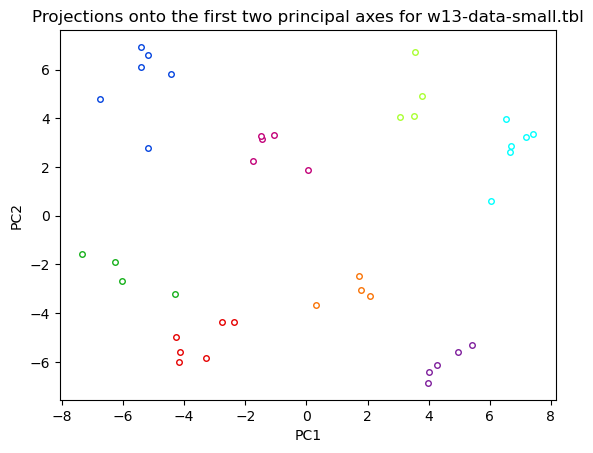

In [3]:
# for small data set
X_s, ctype_s, ncells_s, ngenes_s, infile_s = read_data("w13-data-small.tbl")
X_log_s = log_transform(X_s, ncells_s, ngenes_s)
PCA(X_s, ncells_s, ctype_s, infile_s)

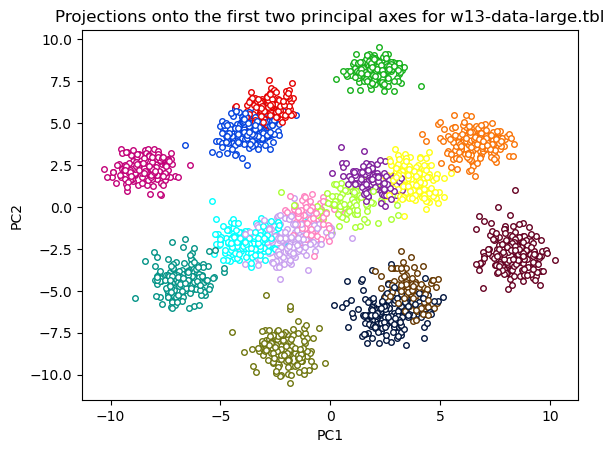

In [4]:
# for large data set
X_l, ctype_l, ncells_l, ngenes_l, infile_l = read_data("w13-data-large.tbl")
X_log_l = log_transform(X_l, ncells_l, ngenes_l)
PCA(X_l, ncells_l, ctype_l, infile_l)

Based on the above visualizations of the projections onto the first two principal axes using PCA on the two respective data sets, we observe that there are considerable amounts of overlap between clusters in the large data set despite being distinct neural cell type clusters. 

Thus, it is evident that PCA's rigid linear projections limit our ability to separate the distinct clusters when the amount of variance captured by the first two principal components become insufficient to explain an appropriate amount of variance for high-dimensional data sets; instead, we may consider t-SNE as a potential solution to the problem as it yields non-linear projections.

#### 2. Implement t-SNE

Here, we will attempt to implement our own t-SNE algorithm based on descriptions given in lecture and the paper by van der Maaten and Hinton (2008) [1]; for simplicity, we will use SciPy's ```scipy.optimize.minimize()``` optimizer instead of implementing the t-SNE optimization method.

Subsequently, we will use our implementation of t-SNE to visualize Moriarty's smaller data set in two t-SNE dimensions.

In [5]:
def calculate_dist(X):
    """
    Calculates the distance between each pair of points in the data set and stores it in a matrix D.
    """
    D = np.zeros((X.shape[0], X.shape[0]))
    for i in range(D.shape[0]):
        for j in range(D.shape[0]):
            if i != j:
                D[i, j] = np.linalg.norm(X[i]-X[j])
                
    return D


def perplexity_diff(sigma_i, D_i, perplexity_true):
    """
    Calculates the perplexity difference.
    """
    P_ji = np.where(D_i == 0, 1, np.exp(-D_i**2/(2*sigma_i**2)))/(sum(np.exp(-D_i**2/(2*sigma_i**2)))-1)
    H_i = -sum(P_ji*np.log2(P_ji))
    perplexity_i = 2**H_i
    difference = perplexity_i - perplexity_true
    
    return difference


def calculate_sigma(X, perplexity_true):
    """
    Calculates sigma for each point i.
    """
    D = calculate_dist(X)
    sigma = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        a = 1.0
        while perplexity_diff(a, D[i], perplexity_true) > 0:
            a /= 2
        b = 1.0
        while perplexity_diff(b, D[i], perplexity_true) < 0:
            b *= 2
        sigma[i] = optimize.bisect(perplexity_diff, a, b, args = (D[i], perplexity_true))
        
    return sigma


def calculate_conditional(X, sigma, D):
    """
    Calculates the conditional probability, P_j|i.
    """
    P_ji = np.zeros((D.shape))
    for i in range(D.shape[0]):
        num = np.exp(-D[i]**2/(2*sigma[i]**2))
        num[i] = 0
        P_ji[i] = num/np.sum(num)
        
    P_ji = (P_ji+P_ji.T)/(2*D.shape[0])
    
    return P_ji


def calculate_Q(Y):
    """
    Calculates Q from Y.
    """
    D_Y = calculate_dist(Y)
    
    Q = np.empty((1, Y.shape[0]))
    for i in range(D_Y.shape[0]):
        q = (D_Y[i]**2+1)**(-1)
        q[int(np.where(D_Y[i] == 0)[0])] = 0
        q = q.reshape((1, D_Y.shape[0]))
        Q = np.concatenate((Q, q),axis = 0)
        
    Q = np.delete(Q, obj = 0, axis = 0)
    Q = Q/sum(sum(Q))
    
    return Q   


def KL_dist(Y, P):
    """
    Calculates the KL divergence.
    """
    n = P.shape[0]
    Y = np.reshape(Y, (n, 2))
    Q = calculate_Q(Y)
    KL = np.sum(P*(np.log2(P, where = (P != 0)) - np.log2(Q, where = (Q != 0))))
    D_Y = calculate_dist(Y)
    
    gradient = np.zeros(Y.shape)
    for i in range(gradient.shape[0]):
        c1 = P[i]-Q[i]
        c2 = (D_Y[i]**2+1)**-1
        for j in range(gradient.shape[1]):
            c3 = np.asarray([Y[i, j]-Y[k, j] for k in range(Y.shape[0])])
            gradient[i, j] = 4*sum(c1*c2*c3)
    
    return KL, gradient.flatten()


def t_SNE(X, perplexity_true):
    """
    Performs t-SNE using user specified perplexity value.
    """
    sigma = calculate_sigma(X, perplexity_true)
    D = calculate_dist(X)
    P = calculate_conditional(X, sigma, D)
    Y = np.random.normal(0, 1e-4, (X.shape[0], 2))
    result = optimize.minimize(KL_dist, Y.flatten(), args = (P), jac = True)
    result = np.reshape(result.x, Y.shape)
    
    return result

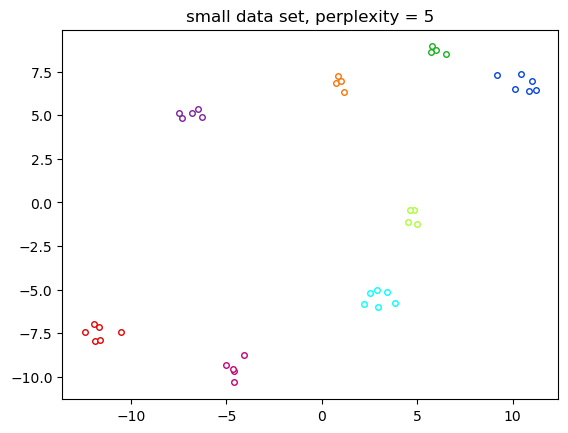

In [6]:
# perform t-SNE on small data set with perplexity = 5
np.random.seed(13)
tSNE = t_SNE(X_log_s, 5)
for i in range(tSNE.shape[0]):
    plt.plot(tSNE[i, 0], tSNE[i, 1], 'o', markersize = 4, mfc = 'w', mec = Color[ctype_s[i]])
plt.title("small data set, perplexity = 5")
plt.show()

Based on the above visualization using our own implementation of t-SNE, we see that it has clustered Moriarty's small data set into the 8 distinct neural cell types to our satisfaction using a perplexity of 5.

Relative to the clustered data points using PCA as demonstrated in part 1, we observe tighter clusters between data points within each cluster when applying our t-SNE implementation, which suggests that the non-linear projections based on t-SNE are more appropriate for high dimensional data sets relative to PCA's rigid linear projections.

#### 3. Using the Canned t-SNE From Scikit

Lastly, we will use the canned t-SNE algorithm from Scikit's ```sklearn.manifold.TSNE``` to visualize both the small and large data sets from Moriarty in two t-SNE dimensions while using four different choices of perplexity: 2, 5, 30, and 100 to elucidate how the choice of perplexity affects the results of t-SNE on our two data sets.

In [ ]:
# perform canned t-SNE on both data sets with varying perplexities
np.random.seed(13)
perplexities = [2, 5, 30, 100]

Y_s, Y_l = [], []
for i in perplexities:
    Y_s.append(TSNE(perplexity = i, learning_rate = 'auto', init = 'random').fit_transform(X_log_s))
    Y_l.append(TSNE(perplexity = i, learning_rate = 'auto', init = 'random').fit_transform(X_log_l))

In [ ]:
# plot the results of canned t-SNE on both data sets with varying perplexities
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
for i in range(len(perplexities)):
    for j in range(len(X_s)):
        ax[0, i].plot(Y_s[i][j, 0], Y_s[i][j, 1], 'o', markersize = 4, mfc = 'w', mec = Color[ctype_s[j]%16])
        ax[0, i].set_title('small data set, perplexity = {}'.format(perplexities[i]))
    for j in range(len(X_l)):
        ax[1, i].plot(Y_l[i][j, 0], Y_l[i][j, 1], 'o', markersize = 4, mfc = 'w', mec = Color[ctype_l[j]%16])
        ax[1, i].set_title('large data set, perplexity = {}'.format(perplexities[i]))
plt.tight_layout()

Based on the above plots, we observe significant variations in the resulting plots from t-SNE for our two data sets as we vary the value of perplexity, which, in essence, is an informed guess of the target number of neighbors for our central points.

By varying the perplexity, we can make a number of observations: first, we see that local variations dominate with a perplexity of 2; second, we see that distinct clusters emerge using a perplexity of 5, and is the most ideal value for the small data set; with a perplexity of 30, clusters begin to emerge for the large data set relative to a perplexity of 5, whereas the data points become more scattered for the small data set relative to a perplexity of 5; lastly, we see that the data points within the clusters of the large data set are ideal and tightly bounded together using a perplexity of 100, whereas the results for the small data set are effectively nonsensical and forms a circular structure as expected since the number of samples in the small data set are less than the value of the perplexity.

Given the above observations, we can conclude that the chosen perplexity value for a given data set should depend on the expected size of each cluster to yield the optimal results; moreover, it becomes obvious that the chosen perplexity value should not exceed the number of samples in a given data set, which would either yield nonsensical results or result in the algorithm throwing an error/warning.

#### References

[1] L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. Journal of Machine Learning Research 9(Nov):2579–2605, 2008.